In [1]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from BaselineRemoval import BaselineRemoval
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import torch
from torch.utils.data import TensorDataset
import torch
from torch import nn
import sys
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# from torch.utils.data import TensorDataset


In [2]:
DATALABEL = ['ear lobe','inner arm','thumb nail','median cubital vein']
WATCH_PROB_PREDICT = False ## if you want to observe the probability of each choice
PLT = '/root/projects/ProjectAug22/CP/Diabete_detection_withRamanSpec/dataset/' ## change to the path to dataset
PLT_mac = '/Volumes/ExternalSSDForMac/AITLecture/CSforDSAIAUG22/_CP_project/DataScienceAndMLProjects/Diabete_detection_withRamanSpec/dataset'

SMOOTH = False

SEED = 1910



## 1. ETL

In [3]:
from src import spectrumloader as spl
from src import get_torch_loader as tlg
# from src.modeltorch_template import NeuralNet,RamConv1d,RamLSTM,RamConv1d_bnmx,IntANN,IntRamLSTM,RamConv1d_mx
from src import trainResult_show as mtp

In [4]:
standard,data_all = spl.read_file('dataset/')

In [5]:
Xs,ys,_ = spl.cut_tonumpy(data_all)

In [6]:
assert len(Xs) == 4, 'DATA error'

## 2.Train test split (with same seed)

In [7]:
X_trainall,_,y_trainall,_ = spl.split_train_test(Xs,ys)
y_train0,y_train1,y_train2,y_train3 = y_trainall

## 3. EDA [here](https://github.com/AtiChetsurakul/DataScienceAndMLProjects/blob/main/Diabete_detection_withRamanSpec/datawatcher.ipynb)
- To shorten the file, eda not inculded

## 4. spectrum tranformation 
- incuding
    - Fluoresence removal
    - Correcting baseline
    - Normalization
## ORDER OF DATA ARE
>(0) ear lobe

>(1) inner arm 

>(2) thumb nail 

>(3) median cubital vein


In [8]:
X_train_VR = spl.fluoresence_removal(X_trainall)
if SMOOTH:
    X_train_VR = spl.savitzky_smooth(X_train_VR)

In [9]:
X_train0_std,X_train1_std,X_train2_std,X_train3_std,normalizer = spl.seting_normalized_fuoresence_smoothing(True,True,X_train_VR)

assert len(normalizer) == 4, 'Normalizer is not here'

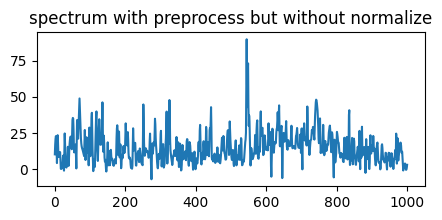

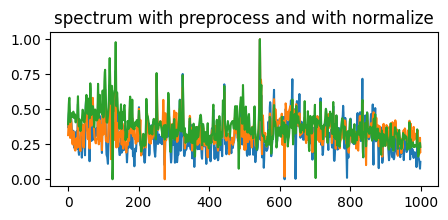

In [10]:
# Check by plot
plt.figure(figsize=(5,2))
plt.plot(X_train_VR[0][0])
plt.title('spectrum with preprocess but without normalize')
plt.show()
plt.figure(figsize=(5,2))
plt.title('spectrum with preprocess and with normalize')
plt.plot(X_train1_std[0])
plt.plot(X_train1_std[7])
plt.plot(X_train1_std[2])

plt.show()

## 5. apply data to pytorch

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [12]:
ds_earloop = TensorDataset(torch.FloatTensor(X_train0_std),torch.LongTensor(y_train0))
ds_inarm = TensorDataset(torch.FloatTensor(X_train1_std),torch.LongTensor(y_train1))
ds_thumbnail = TensorDataset(torch.FloatTensor(X_train2_std),torch.LongTensor(y_train2))
ds_vain = TensorDataset(torch.FloatTensor(X_train3_std),torch.LongTensor(y_train3))



In [13]:
train_size = 12
val_size = 4
batch_size=12
valbatch_size=4
train_loader_all,val_loader_all = tlg.shuffleloadertorch(ds_earloop,ds_inarm,ds_thumbnail,ds_vain,SEED,train_size,val_size,batch_size,valbatch_size)

## 6. modeling


In [14]:
class RamGRU(nn.Module):
    def __init__(self, input_size = 1000, hidden_size=50, out_size=2):
        super().__init__()
        #with dropout
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True, dropout=0.2)
        self.linear = nn.Linear(hidden_size, out_size)
        
    def forward(self, seq):
        out, _ = self.gru(seq)
        out = out[:, -1, :] #(B, Hout)

        out = self.linear(out)
        return out

model = RamGRU().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model


RamGRU(
  (gru): GRU(1000, 50, batch_first=True, dropout=0.2)
  (linear): Linear(in_features=50, out_features=2, bias=True)
)

In [15]:
# EXAM PLE model_RNN_for_earloop = RamLSTM().to(device)

model_RNN_for_earloop = RamGRU().to(device)
model_RNN_for_inarm = RamGRU().to(device)
model_RNN_for_thumbnail = RamGRU().to(device)
model_RNN_for_vain = RamGRU().to(device)


criterion_for_earloop = nn.CrossEntropyLoss()   
optimizer_for_earloop = torch.optim.Adam(model_RNN_for_earloop.parameters(), lr=0.0001)  

criterion_for_inarm= nn.CrossEntropyLoss()   
optimizer_for_inarm = torch.optim.Adam(model_RNN_for_inarm.parameters(), lr=0.0001)  

criterion_for_thumbnail= nn.CrossEntropyLoss()   
optimizer_for_thumbnail = torch.optim.Adam(model_RNN_for_thumbnail.parameters(), lr=0.0001)

criterion_for_vain = nn.CrossEntropyLoss()   
optimizer_for_vain = torch.optim.Adam(model_RNN_for_vain.parameters(), lr=0.0001)  

simRNN_models = [model_RNN_for_earloop,model_RNN_for_inarm,model_RNN_for_thumbnail,model_RNN_for_vain]
simRNN_criterions = [criterion_for_earloop,criterion_for_inarm,criterion_for_thumbnail,criterion_for_vain]
simRNN_optims = [optimizer_for_earloop,optimizer_for_inarm,optimizer_for_thumbnail,optimizer_for_vain]

In [16]:
simRNN_models[0]

RamGRU(
  (gru): GRU(1000, 50, batch_first=True, dropout=0.2)
  (linear): Linear(in_features=50, out_features=2, bias=True)
)

In [17]:
total_step = train_size/batch_size  #for printing purpose
num_epochs = 5000

train_loss_each_location = []
val_loss_each_location = []
val_acc_each_location = []

for model,criterion,optimizer,each_train_loader,each_val_loader,datasetlabel in zip(simRNN_models,simRNN_criterions,simRNN_optims,train_loader_all,val_loader_all,DATALABEL):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        for i, (spec, y) in enumerate(each_train_loader):  
            model.train()

            spec = spec.reshape(spec.shape[0],1,-1).to(device)
            y = y.to(device)
                    
            # Forward pass
            outputs = model(spec)
            loss = criterion(outputs, y)  
        
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i) % 50 == 0:
                sys.stdout.write('\rEpoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        if (epoch+1) % 40 == 0:
            with torch.no_grad():
                model.eval()
                total_val_corr = 0
                for (val_spec, val_label) in each_val_loader:
                    val_spec = val_spec.reshape(val_spec.shape[0],1,-1).to(device)
                    val_label = val_label.to(device)
                    val_yhat = model(val_spec)
                    val_loss = criterion(val_yhat, val_label)

                    train_losses.append(loss.cpu().detach().numpy())
                    val_losses.append(val_loss.cpu().detach().numpy())

                    val_predicted = torch.max(val_yhat, 1)[1]
                    total_val_corr += (val_predicted == val_label).sum()
                val_acc = (total_val_corr * 100) / val_size
                print(f"    ++++++Validation++++++  Loss: {val_loss:.2f} - Acc: {val_acc:.2f}",end = ' ')
    print(f'\n END OF MODEL for {datasetlabel} with val acc = {val_acc}')
    train_loss_each_location.append(train_losses)
    val_loss_each_location.append(val_losses)
    val_acc_each_location.append(val_acc)

Epoch [5000/5000], Step [1/1.0], Loss: 0.0002    ++++++Validation++++++  Loss: 6.55 - Acc: 0.00     ++++++Validation++++++  Loss: 5.18 - Acc: 0.00     ++++++Validation++++++  Loss: 6.00 - Acc: 0.00     ++++++Validation++++++  Loss: 6.14 - Acc: 0.00     ++++++Validation++++++  Loss: 6.33 - Acc: 0.00 
 END OF MODEL for ear lobe with val acc = 0.0
Epoch [5000/5000], Step [1/1.0], Loss: 0.0002    ++++++Validation++++++  Loss: 3.61 - Acc: 25.00 
 END OF MODEL for inner arm with val acc = 25.0
Epoch [5000/5000], Step [1/1.0], Loss: 0.0002    ++++++Validation++++++  Loss: 0.26 - Acc: 100.00    ++++++Validation++++++  Loss: 0.32 - Acc: 100.00     ++++++Validation++++++  Loss: 0.27 - Acc: 100.00 
 END OF MODEL for thumb nail with val acc = 100.0
Epoch [5000/5000], Step [1/1.0], Loss: 0.0004    ++++++Validation++++++  Loss: 7.24 - Acc: 0.00     ++++++Validation++++++  Loss: 7.15 - Acc: 0.00 
 END OF MODEL for median cubital vein with val acc = 0.0


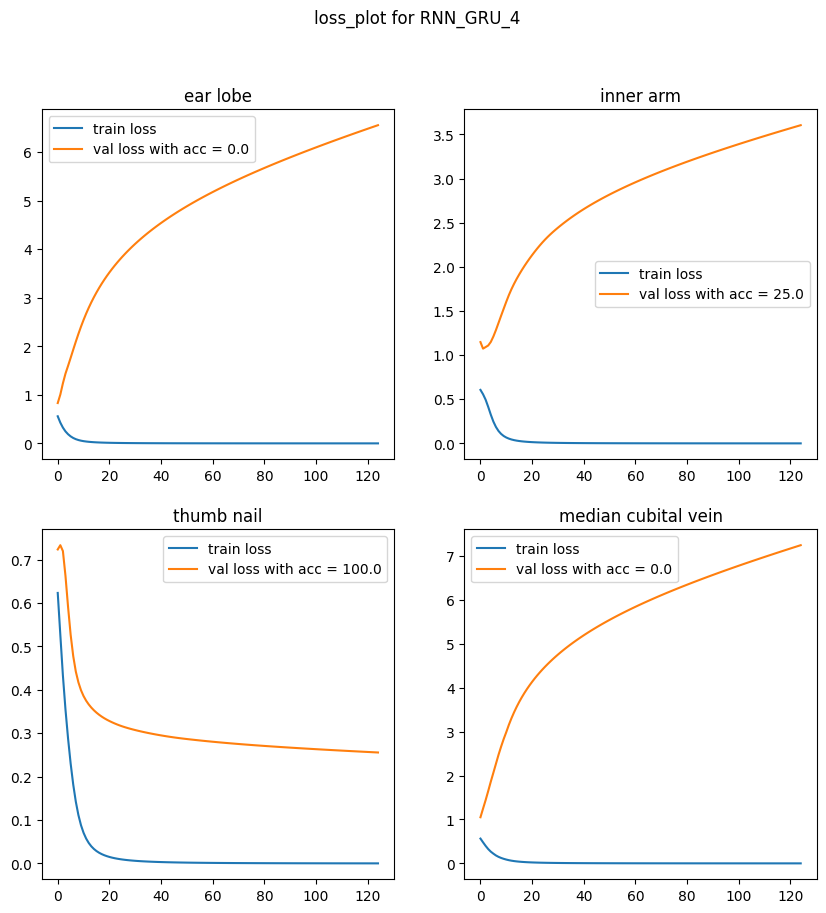

In [18]:
if WATCH_PROB_PREDICT:
    with torch.no_grad():
        print('trainpred ',simRNN_models[-1](spec),'\n',y,'\n val\n',simRNN_models[-1](val_spec),val_label)
        print(criterion(simRNN_models[-1](val_spec),val_label))
mtp.loss_plot_sub(train_loss_each_location,val_loss_each_location,val_acc_each_location,DATALABEL,'RNN_GRU_4')

In [19]:
standard,data_all = spl.read_file('dataset/')
Xs,ys,_ = spl.cut_tonumpy(data_all)
assert len(Xs) == 4, 'DATA error'

_,X_testall,_,y_testall = spl.split_train_test(Xs,ys)
X_test_VR = spl.fluoresence_removal(X_testall)
X_test0_std,X_test1_std,X_test2_std,X_test3_std,normalizer2 = spl.seting_normalized_fuoresence_smoothing(True,True,X_test_VR)

assert len(normalizer2) == 4, 'Normalizer is not here'

y_test0,y_test1,y_test2,y_test3 = y_testall

ds_test_earloop = TensorDataset(torch.FloatTensor(X_test0_std),torch.LongTensor(y_test0))
ds_test_inarm = TensorDataset(torch.FloatTensor(X_test1_std),torch.LongTensor(y_test1))
ds_test_thumbnail = TensorDataset(torch.FloatTensor(X_test2_std),torch.LongTensor(y_test2))
ds_test_vain = TensorDataset(torch.FloatTensor(X_test3_std),torch.LongTensor(y_test3))
batch_size =4 

test_loader0 = torch.utils.data.DataLoader(dataset=ds_test_earloop,batch_size=batch_size,shuffle=True)
test_loader1 = torch.utils.data.DataLoader(dataset=ds_test_inarm,batch_size=batch_size,shuffle=True)
test_loader2 = torch.utils.data.DataLoader(dataset=ds_test_thumbnail,batch_size=batch_size,shuffle=True)
test_loader3 = torch.utils.data.DataLoader(dataset=ds_test_vain,batch_size=batch_size,shuffle=True)


test_loader_all = [test_loader0,test_loader1,test_loader2,test_loader3]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
with torch.no_grad():
    for each_loc_test, each_loc_model in zip(test_loader_all,simRNN_models):
        correct = 0
        for i, (spec, y) in enumerate(each_loc_test):  

            spec = spec.reshape(spec.shape[0],1,-1).to(device)
            y_test = y.to(device)

            y_hat = each_loc_model(spec)
            print(y_hat)
            predicted = torch.max(y_hat,1)[1]
            correct += (predicted == y_test).sum()
        print(f'Test accuracy: {correct.item()}/{len(y_test0)} = {correct.item()*100/(len(y_test0)):7.3f}%')

# if SMOOTH:
#     X_test_VR = spl.savitzky_smooth(X_test_VR)

tensor([[-2.2944,  2.7885],
        [-0.5150,  0.9071],
        [ 4.1217, -4.8581],
        [-4.5787,  5.5300]])
Test accuracy: 4/4 = 100.000%
tensor([[ 1.6860, -2.5605],
        [-1.2007,  1.5171],
        [-1.1408,  1.5037],
        [-2.2112,  3.0745]])
Test accuracy: 4/4 = 100.000%
tensor([[-0.8146,  1.1936],
        [-0.7583,  1.2596],
        [-3.7488,  4.1900],
        [ 2.2521, -1.7997]])
Test accuracy: 4/4 = 100.000%
tensor([[-4.0221,  3.8050],
        [-4.5435,  4.2681],
        [-1.8371,  1.9540],
        [ 1.9624, -1.6271]])
Test accuracy: 4/4 = 100.000%


------- breaking point -----------
the testing results are 100% accuracy, which is not possible. i think there are something wrong with the testing data. i will try to find out what is wrong with the testing data. However, we have no problem with validation data since we already tried training/validating and it works like how it should be! May be because of the small size of the data, the model is overfitting. I will try to add more data if it's available! but for this project! i will stop here. But, I believe that I have made my point here of proving the efficieny of RNN and GRU in this project. NO WONDER it's getting popular these days!